## Time Series Comparisons: Fluxes versus Forcing Functions

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [13]:
plt.rcParams['font.size'] = 16

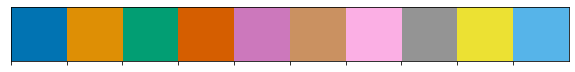

In [3]:
sns.set_palette(sns.color_palette("colorblind"))
myp = sns.color_palette('colorblind')
sns.palplot(myp)

In [4]:
# Fluxes
shallow_flux = pd.read_csv('shallowflux.csv', parse_dates=[0], index_col=0)
deep_flux = pd.read_csv('deepflux.csv', parse_dates=[0], index_col=0)
baroclinic = shallow_flux + deep_flux
barotropic = shallow_flux - deep_flux

In [5]:
# Rivers
r2015 = pd.read_csv('SoG_runoff_2015.csv', parse_dates=True, index_col=0)
r2016 = pd.read_csv('SoG_runoff_2016.csv', index_col=0, parse_dates=True)
r2017 = pd.read_csv('SoG_runoff_2017.csv', index_col=0, parse_dates=True)
r2018 = pd.read_csv('SoG_runoff_2018.csv', index_col=0, parse_dates=True)
SoGrunoff = pd.concat([r2015, r2016, r2017, r2018])

In [6]:
# Wind
wind = pd.read_csv('day_avg_wind.csv', index_col=0)
wind.index = pd.to_datetime(wind.index, format="%Y-%m-%d")
low_pass_wind = wind.rolling(window=4, center=True).mean()

In [7]:
# SSH
ssh = pd.read_csv('low_pass_ssh.csv')
base = datetime.datetime(2015, 1, 1, tzinfo=datetime.timezone.utc)
date_list = [base + datetime.timedelta(days=x) for x in range(1461)]
ssh['time'] = date_list
ssh.set_index('time', inplace=True)

In [8]:
# Tides
low_pass_tide = pd.read_csv('low_pass_tide.csv', index_col=0)
low_pass_tide.index = pd.to_datetime(low_pass_tide.index, format="%Y-%m-%d")

In [9]:
# Density Forcing
sigma = pd.read_csv('sigma_2015_201806.csv', index_col=0)
m2015 = sigma.south - sigma.north
m2015.index = pd.to_datetime(m2015.index, format="%Y-%m-%d")
sigma = pd.read_csv('sigma_2016_201806.csv', index_col=0)
m2016 = sigma.south - sigma.north
m2016.index = pd.to_datetime(m2016.index, format="%Y-%m-%d")
sigma = pd.read_csv('sigma_2017_201806.csv', index_col=0)
m2017 = sigma.south - sigma.north
m2017.index = pd.to_datetime(m2017.index, format="%Y-%m-%d")
sigma = pd.read_csv('sigma_2018_201806.csv', index_col=0)
m2018 = sigma.south - sigma.north
m2018.index = pd.to_datetime(m2018.index, format="%Y-%m-%d")
goverrho=9.81/1000.
depthwidth = 50*10e3
densitydiff = pd.concat([m2015, m2016, m2017, m2018])
densityforcing = np.sqrt(goverrho*densitydiff[:])

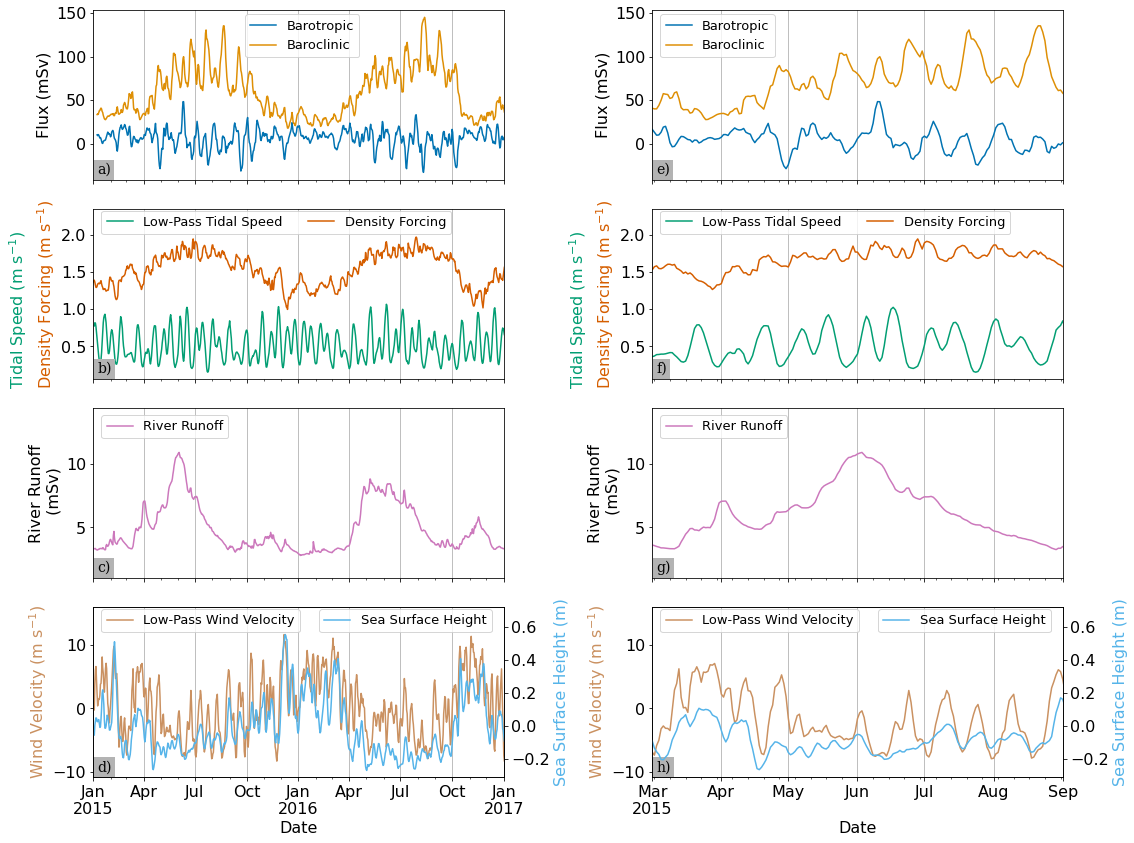

In [69]:
fig, axs = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(wspace=0.25)

mylabels = [['a)', 'e)'], ['b)', 'f)'], ['c)', 'g)'], ['d)', 'h)']]

for iax in range(2):
    (barotropic.transport/1000).plot(ax=axs[0, iax], color=myp[0], label="Barotropic")
    (baroclinic.transport/1000).plot(ax=axs[0, iax], color=myp[1], label="Baroclinic")
    low_pass_tide.vozocrtx.plot(ax=axs[1, iax], color=myp[2], label="Low-Pass Tidal Speed")
    densityforcing.plot(ax=axs[1, iax], color=myp[3], label="Density Forcing")
    (SoGrunoff.rorunoff/1000).plot(ax=axs[2, iax], color=myp[4], label="River Runoff")
    low_pass_wind.wind.plot(ax=axs[3, iax], color=myp[5], label="Low-Pass Wind Velocity")
    axb = axs[3, iax].twinx()
    axb.set_ylabel('Sea Surface Height (m)',color=myp[9])
    ssh.sossheig.plot(ax=axb, color=myp[9], label="Sea Surface Height")
    axb.legend(loc=[0.55, 0.85], fontsize=13)   
    axb.set_ylim(None, 0.72)
    axb.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])

for ax in axs[:, 0]:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2017, 1, 1))
    
for ax in axs[:, 1]:
    ax.set_xlim(datetime.datetime(2015, 3, 1), datetime.datetime(2015, 9, 1))

for ax in axs[1, :]:
    ax.set_ylim(None, 2.35)
for ax in axs[3, :]:
    ax.set_ylim(None, 16)
    
axs[1, 0].text(datetime.datetime(2014, 8, 1), 0.0, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])
axs[1, 1].text(datetime.datetime(2015, 1, 22), 0.0, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])

for i in range(2):
    axs[3, i].set_xlabel('Date')
    
    axs[0, i].set_ylabel('Flux (mSv)')
    axs[1, i].set_ylabel('Density Forcing (m s$^{-1}$)', color=myp[3])
    axs[2, i].set_ylabel("River Runoff\n (mSv)")
    axs[2, i].set_ylim(bottom=1)
    axs[3, i].set_ylabel('Wind Velocity (m s$^{-1}$)', color=myp[5])
    
    for j in range(3):
        axs[j, i].set_xticklabels([])
        axs[j, i].set_xlabel('')
        axs[j, i].legend(loc='best', fontsize=14)
    for j in range(4):
        axs[j, i].grid(axis='x')
        axs[j, i].text(0.01, 0.02, mylabels[j][i], transform=axs[j, i].transAxes,
            fontsize=14, verticalalignment='bottom', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
axs[0, 0].legend(loc=[0.37, 0.72], fontsize=13)        
axs[0, 1].legend(loc=[0.02, 0.72], fontsize=13)
axs[1, 0].legend(loc=[0.02, 0.85], fontsize=13, ncol=2)        
axs[1, 1].legend(loc=[0.02, 0.85], fontsize=13, ncol=2)
axs[2, 0].legend(loc=[0.02, 0.82], fontsize=13)        
axs[2, 1].legend(loc=[0.02, 0.82], fontsize=13)
axs[3, 0].legend(loc=[0.02, 0.85], fontsize=13)        
axs[3, 1].legend(loc=[0.02, 0.85], fontsize=13)

fig.tight_layout()
plt.savefig('Ancillary.pdf')
plt.savefig('Ancillary.png')

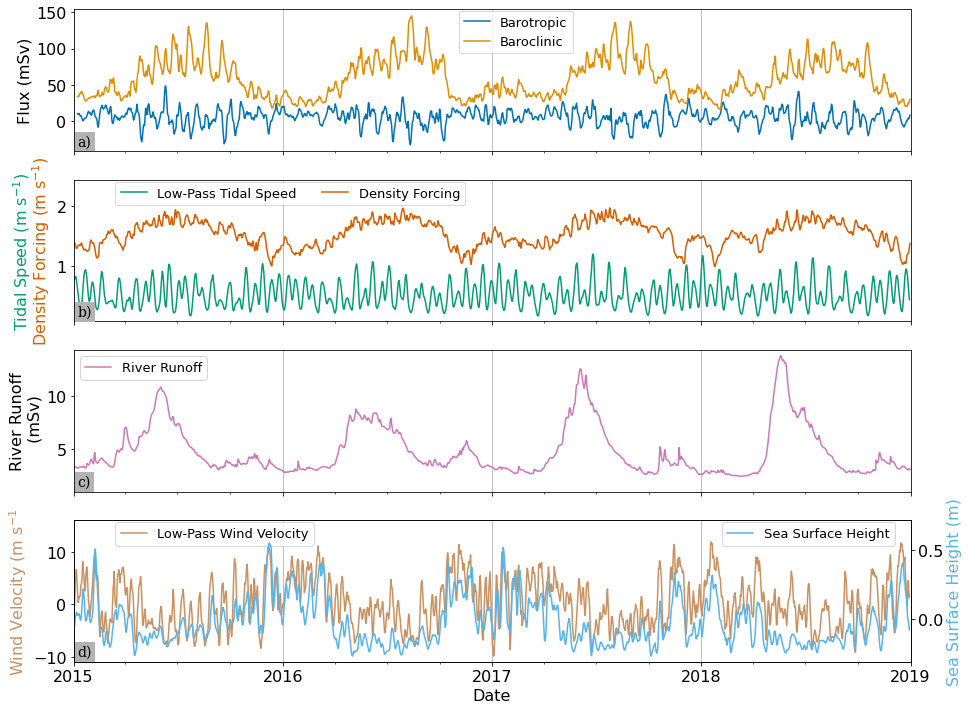

In [108]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12))
fig.subplots_adjust(wspace=0.25)

mylabels = ['a)', 'b)', 'c)', 'd)']

(barotropic.transport/1000).plot(ax=axs[0], color=myp[0], label="Barotropic")
(baroclinic.transport/1000).plot(ax=axs[0], color=myp[1], label="Baroclinic")
#a1l1, = axs[1].plot(low_pass_tide.index, low_pass_tide.vozocrtx, color=myp[2], label="Low-Pass Tidal Speed")
low_pass_tide.vozocrtx.plot(ax=axs[1], color=myp[2], label="Low-Pass Tidal Speed")
#a1l2, = axs[1].plot(densityforcing.index, densityforcing, color=myp[3], label="Density Forcing")
densityforcing.plot(ax=axs[1], color=myp[3], label="Density Forcing")
(SoGrunoff.rorunoff/1000).plot(ax=axs[2], color=myp[4], label="River Runoff")
low_pass_wind.wind.plot(ax=axs[3], color=myp[5], label="Low-Pass Wind Velocity")
axb = axs[3].twinx()
axb.set_ylabel('Sea Surface Height (m)',color=myp[9])
ssh.sossheig.plot(ax=axb, color=myp[9], label="Sea Surface Height")
axb.legend(loc=[0.775, 0.82], fontsize=13)   
axb.set_ylim(None, 0.72)
    

for ax in axs:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2019, 1, 1))

axs[1].set_ylim(None, 2.45)    
axs[3].set_ylim(None, 16)
        
axs[1].text(datetime.datetime(2014, 9, 15), 0.0, 'Tidal Speed (m s$^{-1}$)', rotation=90, color=myp[2])


axs[3].set_xlabel('Date')

axs[0].set_ylabel('Flux (mSv)')
axs[1].set_ylabel('Density Forcing (m s$^{-1}$)', color=myp[3])
axs[2].set_ylabel("River Runoff\n (mSv)")
axs[2].set_ylim(bottom=1)
axs[3].set_ylabel('Wind Velocity (m s$^{-1}$', color=myp[5])
    
for j in range(3):
    axs[j].set_xticklabels([])
    axs[j].set_xlabel('')
    axs[j].legend(loc='best')
axs[0].legend(loc=(0.46, 0.69), fontsize=13)
axs[1].legend(loc=(0.05, 0.82), fontsize=13, ncol=2)
axs[2].legend(loc='best', fontsize=13)
axs[3].legend(loc=[0.05, 0.82], fontsize=13)      
for j in range(4):
    axs[j].grid(axis='x')
    axs[j].text(0.005, 0.02, mylabels[j], transform=axs[j].transAxes,
        fontsize=14, verticalalignment='bottom', fontfamily='serif',
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
        
plt.savefig('Ancillary_sup.pdf')
plt.savefig('Ancillary_sup.png')

In [11]:
plt.rcParams['font.size'] = 14

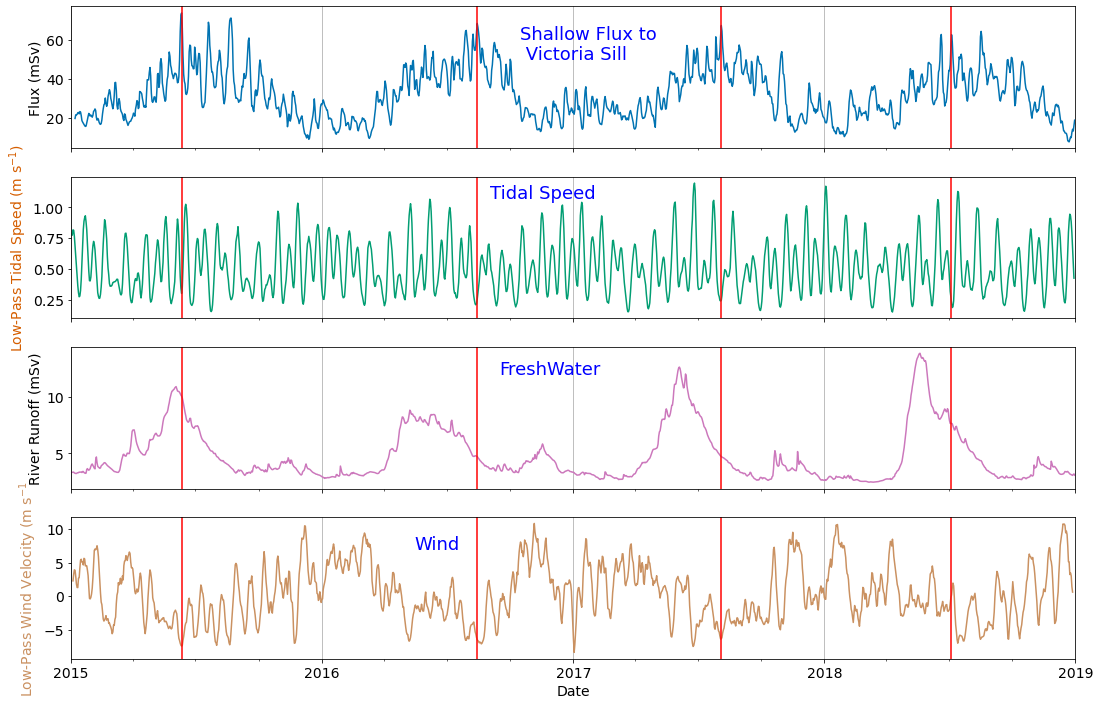

In [12]:
fig, axs = plt.subplots(4, 1, figsize=(18, 12))
fig.subplots_adjust(wspace=0.25)


(shallow_flux.transport/1000).plot(ax=axs[0], color=myp[0], label="Shallow Flux")    
low_pass_tide.vozocrtx.plot(ax=axs[1], color=myp[2], label="Low-Pass Tidal Speed")
(SoGrunoff.rorunoff/1000).plot(ax=axs[2], color=myp[4], label="River Runoff")
low_pass_wind.wind.plot(ax=axs[3], color=myp[5], label="Low-Pass Wind Velocity")
    

for ax in axs[:]:
    ax.set_xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2019, 1, 1))
    

axs[3].set_xlabel('Date')
    
axs[0].set_ylabel('Flux (mSv)')
axs[1].set_ylabel('Low-Pass Tidal Speed (m s$^{-1}$)', color=myp[3])
axs[2].set_ylabel("River Runoff (mSv)")
axs[3].set_ylabel('Low-Pass Wind Velocity (m s$^{-1}$', color=myp[5])
    
for j in range(3):
        axs[j].set_xticklabels([])
        axs[j].set_xlabel('')
for j in range(4):
        axs[j].grid(axis='x')
        
axs[0].text(datetime.datetime(2016, 10, 15), 50, 'Shallow Flux to\n Victoria Sill', color='b', fontsize=18);
axs[1].text(datetime.datetime(2016, 9, 1), 1.07, 'Tidal Speed', color='b', fontsize=18);
axs[2].text(datetime.datetime(2016, 9, 15), 12, 'FreshWater', color='b', fontsize=18);
axs[3].text(datetime.datetime(2016, 5, 15), 7, 'Wind', color='b', fontsize=18);

p1 = datetime.datetime(2015, 6, 11)
for ax in axs:
    ax.axvline(x=p1, color='r')
    
p2 = datetime.datetime(2016, 8, 13)
for ax in axs:
    ax.axvline(x=p2, color='r')
    
p3 = datetime.datetime(2017, 8, 3)
for ax in axs:
    ax.axvline(x=p3, color='r')
    
p4 = datetime.datetime(2018, 7, 4)
for ax in axs:
    ax.axvline(x=p4, color='r')

#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/Leblond_forcing.png')

In [13]:
## Just Look at Barotropic Flux

In [14]:
barotropic[0:2]

,transport
2015-01-01 00:00:00+00:00,NaN
2015-01-02 00:00:00+00:00,NaN


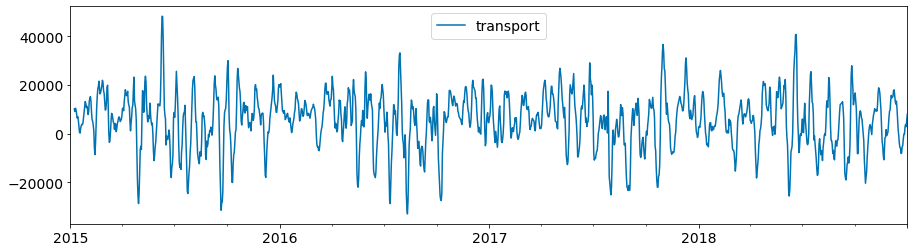

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.plot(ax=ax);

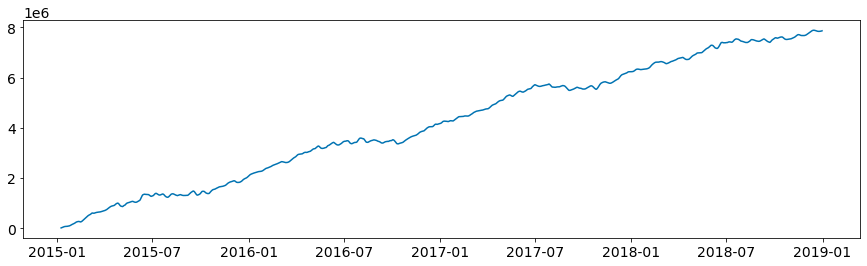

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(barotropic.index, np.cumsum(barotropic.transport));

In [17]:
## So consistently out

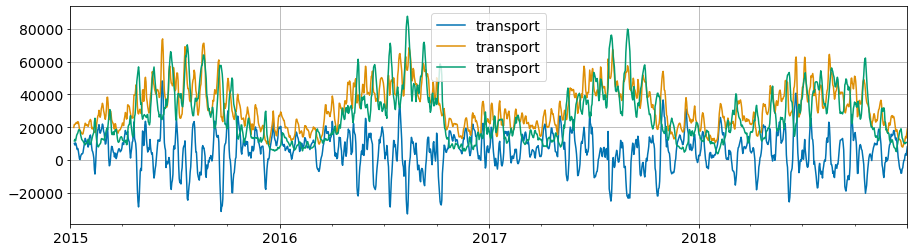

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.plot(ax=ax);
shallow_flux.plot(ax=ax);
deep_flux.plot(ax=ax);
#ax.set_xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31))
ax.grid();

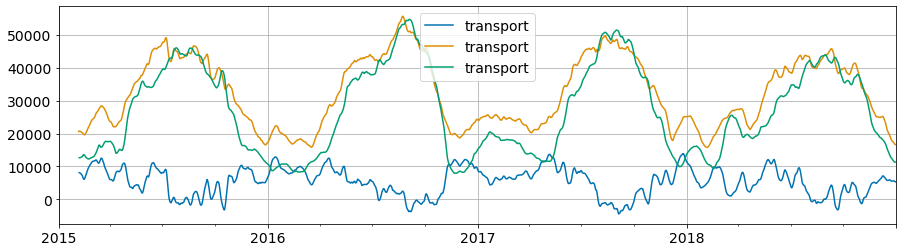

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.rolling(window=30).mean().plot(ax=ax);
shallow_flux.rolling(window=30).mean().plot(ax=ax);
deep_flux.rolling(window=30).mean().plot(ax=ax);
#ax.set_xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31))
ax.grid();

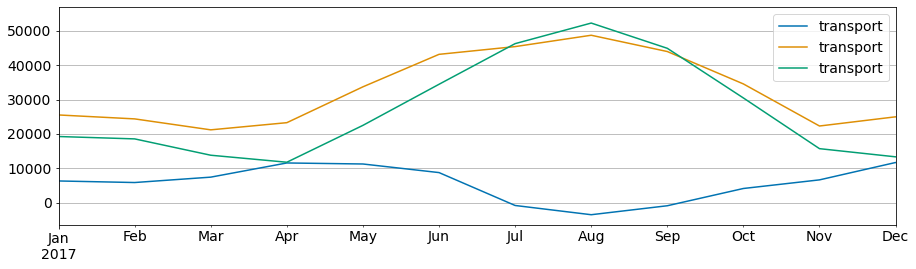

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
barotropic.resample('M').mean().plot(ax=ax);
shallow_flux.resample('M').mean().plot(ax=ax);
deep_flux.resample('M').mean().plot(ax=ax);
ax.set_xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31))
ax.grid();

In [21]:
print(23.8+8)
shallow_flux.mean()

31.8


transport    32148.180265
dtype: float64

In [22]:
print(23.7+2.2)
deep_flux.mean()

25.9


transport    26750.82219
dtype: float64

Yearly Values

In [25]:
SoGrunoff.groupby(SoGrunoff.index.year).mean()

,rorunoff
datetime,
2015,4918.779428
2016,4854.659295
2017,4719.688140
2018,4726.770248


In [27]:
densityforcing.groupby(densityforcing.index.year).mean()

2015    1.538397
2016    1.526091
2017    1.559422
2018    1.535584
dtype: float64

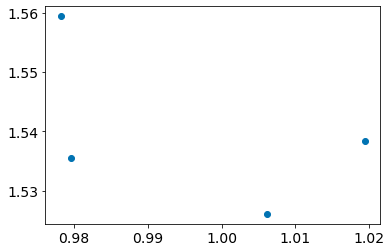

In [31]:
plt.plot(SoGrunoff.groupby(SoGrunoff.index.year).mean()/4825, densityforcing.groupby(densityforcing.index.year).mean(), 'o')

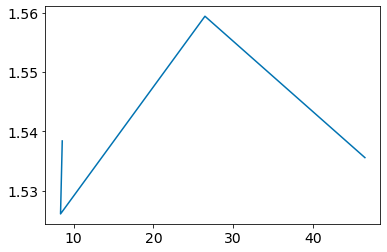

In [52]:
plt.plot(-ssh.groupby(ssh.index.year).sossheig.mean().values*
         (SoGrunoff.groupby(SoGrunoff.index.year).mean().values.transpose()[0]-4000), 
            densityforcing.groupby(densityforcing.index.year).mean().values)

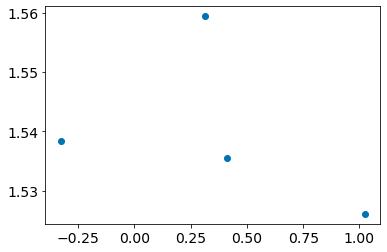

In [55]:
plt.plot(low_pass_wind.wind.groupby(low_pass_wind.index.year).mean(),
          densityforcing.groupby(densityforcing.index.year).mean(), 'o')

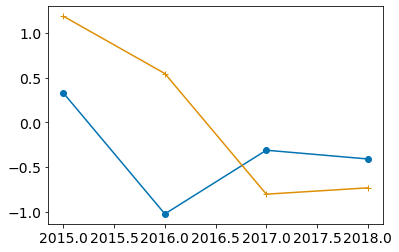

In [81]:
plt.plot(-low_pass_wind.wind.groupby(low_pass_wind.index.year).mean(), 'o-')
plt.plot((SoGrunoff.groupby(SoGrunoff.index.year).mean()-4800)/100, '+-')
#plt.plot(20*(densityforcing.groupby(densityforcing.index.year).mean()-1.52), 's-')
#plt.plot(np.arange(2015, 2019), -(SoGrunoff.groupby(SoGrunoff.index.year).mean().values.transpose()[0]-4800)/100 
#         -low_pass_wind.wind.groupby(low_pass_wind.index.year).mean().values, '*--')